### Final Project Approach

Create a library of short moves: W, NW, N, NE, E

Create pathfinding alg that operates within box (100 in. long, 90 in wide from net to net) and the five short moves

Obstacle detection + belief map:

In [6]:
# Code adapted from: https://github.com/bitcraze/crazyflie-lib-python/blob/master/examples/autonomousSequence.py

import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

# CrazyFlie imports:

import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.crazyflie.syncLogger import SyncLogger
from cflib.positioning.position_hl_commander import PositionHlCommander


ModuleNotFoundError: No module named 'sample_crazyflie'

### k means for obstacle detection

In [2]:
from sklearn.cluster import KMeans
# NOTE: This cell breaking? run:
# pip install scikit-learn

def perform_k_means_clustering(coords, k):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(coords)
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    cluster_sizes = np.bincount(labels)
    return cluster_centers, cluster_sizes


### Determine direction of least obstacles

In [3]:

# Note: This does not account for drone's position in space
def which_way(frame_width, centers, sizes):
    # Step 1: Divide the field of view
    section_width = frame_width / 3

    # Step 2: Assign clusters to sections
    sections = {'left': [], 'forward': [], 'right': []}
    for center, size in zip(centers, sizes):
        if center[0] < section_width:
            sections['left'].append(size)
        elif center[0] < 2 * section_width:
            sections['forward'].append(size)
        else:
            sections['right'].append(size)

    # Step 3: Calculate obstacle density
    densities = {direction: sum(sizes) / section_width for direction, sizes in sections.items()}

    # Step 4: Choose direction
    return min(densities, key=densities.get)

### Movement

In [7]:
def move_forward_and_left(cf, duration=2):
    # Simultaneously move forward and to the left
    cf.commander.send_velocity_world_setpoint(0.3, -0.3, 0, 0)

    # Allow time for the motion (you may adjust the duration)
    time.sleep(duration)

    # Stop the drone
    cf.commander.send_stop_setpoint()

def move_forward_and_right(cf, duration=2):
    # Simultaneously move forward and to the right
    cf.commander.send_velocity_world_setpoint(0.3, 0.3, 0, 0)

    # Allow time for the motion (you may adjust the duration)
    time.sleep(duration)

    # Stop the drone
    cf.commander.send_stop_setpoint()

def move_forward(cf, duration=2):
    cf.commander.send_velocity_world_setpoint(0.3, 0, 0, 0)

    # Allow time for the motion (you may adjust the duration)
    time.sleep(duration)

    # Stop the drone
    cf.commander.send_stop_setpoint()

# Get the current crazyflie position:
def position_estimate(scf):
    log_config = LogConfig(name='Kalman Variance', period_in_ms=500)
    log_config.add_variable('kalman.varPX', 'float')
    log_config.add_variable('kalman.varPY', 'float')
    log_config.add_variable('kalman.varPZ', 'float')

    with SyncLogger(scf, log_config) as logger:
        for log_entry in logger:
            data = log_entry[1]
            x = data['kalman.varPX']
            y = data['kalman.varPY']
            z = data['kalman.varPZ']
            
    print(x, y, z)
    return x, y, z


# Set the built-in PID controller:
def set_PID_controller(cf):
    # Set the PID Controller:
    print('Initializing PID Controller')
    cf.param.set_value('stabilizer.controller', '1')
    cf.param.set_value('kalman.resetEstimation', '1')
    time.sleep(0.1)
    cf.param.set_value('kalman.resetEstimation', '0')
    time.sleep(2)
    return


# Ascend and hover at 1m:
def ascend_and_hover(cf):
    # Ascend:
    for y in range(5):
        cf.commander.send_hover_setpoint(0, 0, 0, y / 10)
        time.sleep(0.1)
    # Hover at 0.5 meters:
    for _ in range(20):
        cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
        time.sleep(0.1)
    return


# Sort through contours in the image
def findGreatesContour(contours):
    largest_area = 0
    largest_contour_index = -1
    i = 0
    total_contours = len(contours)

    while i < total_contours:
        area = cv2.contourArea(contours[i])
        if area > largest_area:
            largest_area = area
            largest_contour_index = i
        i += 1

    #print(largest_area)

    return largest_area, largest_contour_index


# Find contours in the image
def check_contours(frame):

    print('Checking image:')

    # These define the upper and lower HSV for the red obstacles.
    # Note that the red color wraps around 180, so there are two intervals.
    # Tuning of these values will vary depending on the camera.
    lb1 = (145, 35, 75)
    ub1 = (180, 255, 255)
    lb2 = (0, 75, 75)
    ub2 = (20, 255, 255)

    # Perform contour detection on the input frame.
    hsv1 = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    hsv2 = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Compute mask of red obstacles in either color range.
    mask1 = cv2.inRange(hsv1, lb1, ub1)
    mask2 = cv2.inRange(hsv2, lb2, ub2)
    # Combine the masks.
    mask = cv2.bitwise_or(mask1, mask2)

    # Use the OpenCV findContours function.
    # Note that there are three outputs, but we discard the first one.
    _, contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    largest_area, largest_contour_index = findGreatesContour(contours)

    print(largest_area)

    if largest_area > 100:
        return True
    else:
        return False


# Follow the setpoint sequence trajectory:
def adjust_position(cf, current_y):

    print('Adjusting position')

    steps_per_meter = int(10)
    # Set the number here (the iterations of the for-loop) to the number of side steps.
    # You may choose to tune the number and size of the steps.
    for i in range(3): 
        current_y = current_y - 1.0/float(steps_per_meter)
        position = [0, current_y, 0.5, 0.0]

        print('Setting position {}'.format(position))
        for i in range(10):
            cf.commander.send_position_setpoint(position[0],
                                                position[1],
                                                position[2],
                                                position[3])
            time.sleep(0.1)

    cf.commander.send_stop_setpoint()
    # Make sure that the last packet leaves before the link is closed.
    # The message queue is not flushed before closing.
    time.sleep(0.1)
    return current_y


# Hover, descend, and stop all motion:
def hover_and_descend(cf):
    print('Descending:')
    # Hover at 0.5 meters:
    for _ in range(30):
        cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
        time.sleep(0.1)
    # Descend:
    for y in range(10):
        cf.commander.send_hover_setpoint(0, 0, 0, (10 - y) / 25)
        time.sleep(0.1)
    # Stop all motion:
    for i in range(10):
        cf.commander.send_stop_setpoint()
        time.sleep(0.1)
    return

In [4]:
group_number = 16

# Possibly try 0, 1, 2 ...
camera = 0

In [5]:
%matplotlib notebook

In [6]:
# states:
SCANNING = 0
MOVING = 1

<IPython.core.display.Javascript object>


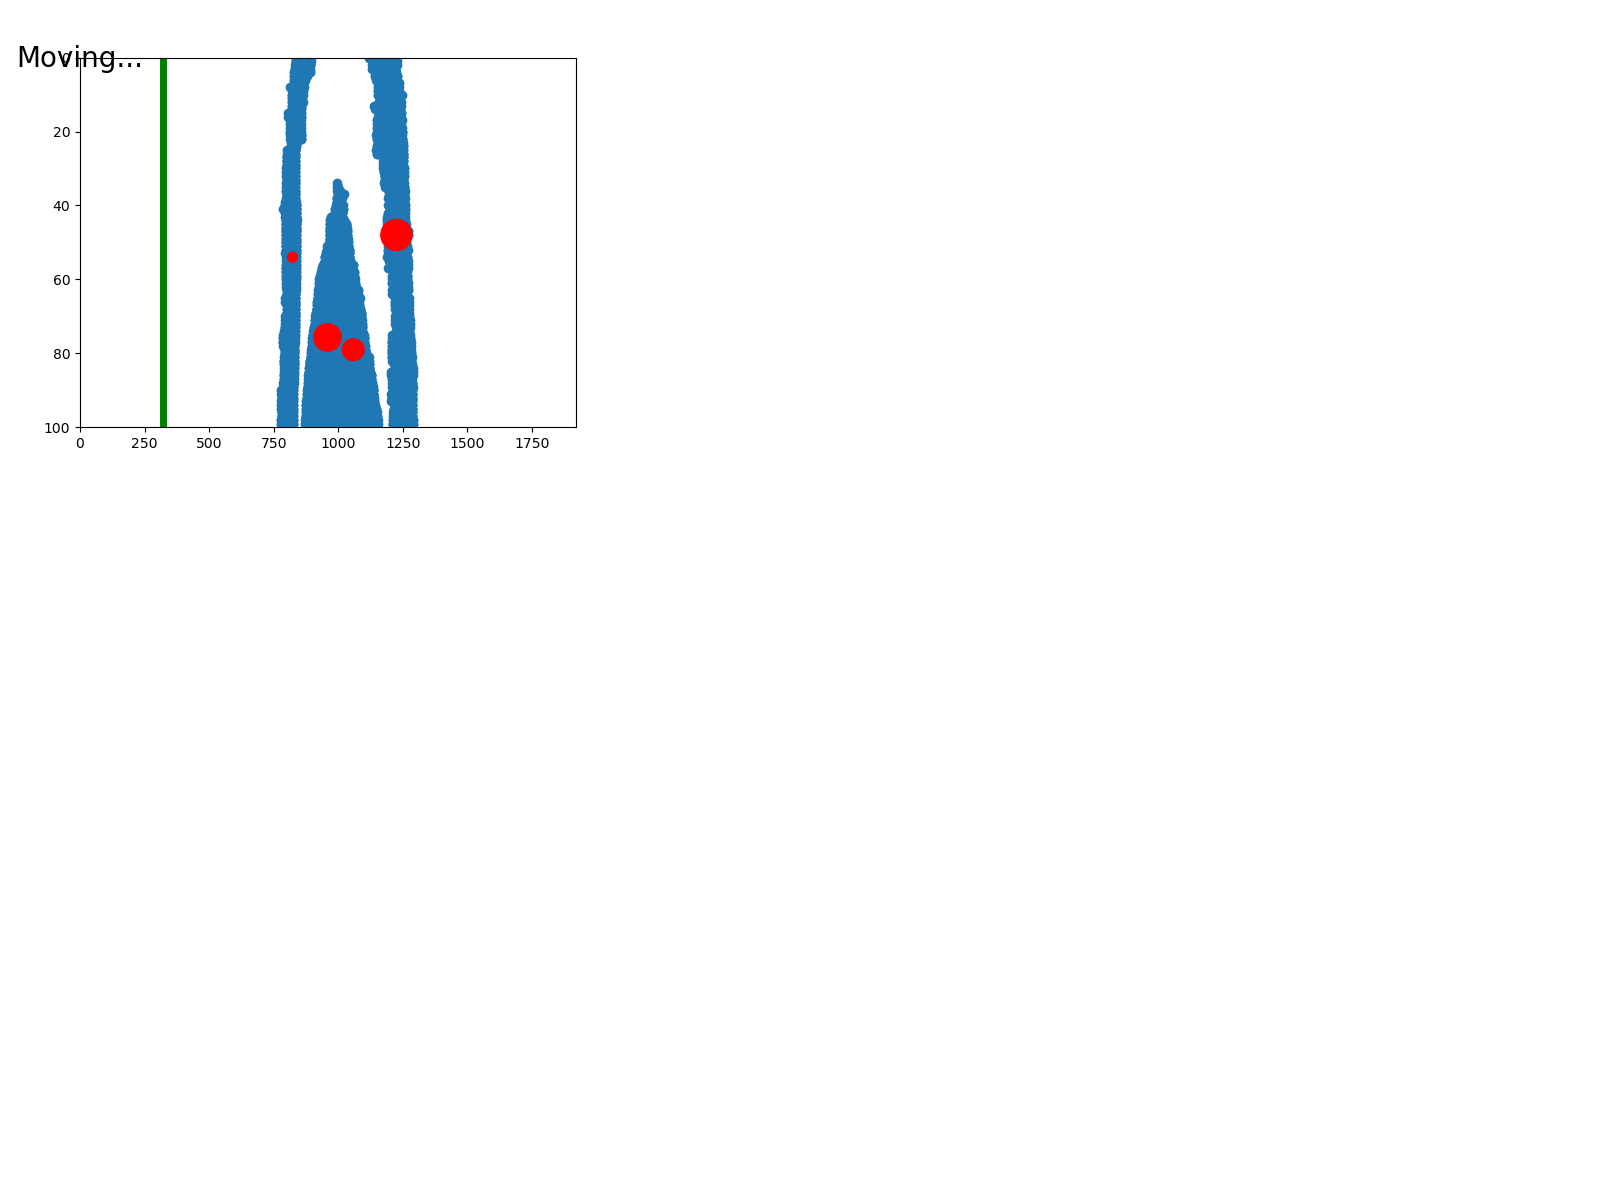

In [ ]:
cap = cv2.VideoCapture(camera)

state = SCANNING

frames = []

fig, ax = plt.subplots()
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    if state == SCANNING:
        frames.append(frame)

        # plot a piece of text that just says "Scanning..."
        ax.text(0.5, 0.5, 'Scanning...', horizontalalignment='center', verticalalignment='center', fontsize=20)
        fig.canvas.draw()

        if len(frames) >= 10:
            # Compute the median frame
            median_frame = np.median(frames, axis=0).astype(dtype=np.uint8)
            frame = median_frame

            # These define the upper and lower HSV for the red obstacles.
            # Note that the red color wraps around 180, so there are two intervals.
            # Tuning of these values will vary depending on the camera.
            lb1 = (145, 35, 75)
            ub1 = (180, 255, 255)
            lb2 = (0, 75, 75)
            ub2 = (20, 255, 255)

            # Perform contour detection on the input frame.
            hsv1 = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            hsv2 = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

            # Compute mask of red obstacles in either color range.
            mask1 = cv2.inRange(hsv1, lb1, ub1)
            mask2 = cv2.inRange(hsv2, lb2, ub2)
            # Combine the masks.
            mask = cv2.bitwise_or(mask1, mask2)
            mask = mask[frame.shape[0]//2-100:frame.shape[0]//2+0,:] # crop to 200 tall from center

            # count number of 1s in mask
            num_red_pixels = np.count_nonzero(mask)

            # Create a list of tuples that are the height, width of each 1 in the mask
            # print('starting')
            # NOTE: this swaps the j, i coordinates (bc frame is height x width) so we get proper x, y. But note, y is still inverted.
            ones_coords = [[j, i] for i in range(mask.shape[0]) for j in range(mask.shape[1]) if mask[i][j] == 255]
            if len(ones_coords) == 0:
                continue

            # print(len(ones_coords))
            # print('done')
            # Plot the points
            ax.clear()
            ax.set_xlim([0, mask.shape[1]])
            ax.set_ylim([0, mask.shape[0]])
            #invert y axis
            ax.invert_yaxis()
            ax.set_autoscale_on(False)

            ax.scatter(*zip(*ones_coords))
            
            # Plot the k means cluster center as a big red point
            centers, sizes = perform_k_means_clustering(ones_coords, k=4)
            normalized_sizes = 50 + (sizes - min(sizes)) / (max(sizes) - min(sizes)) * 450
            ax.scatter(*zip(*centers), color='red', s=normalized_sizes)

            # Plot the direction
            direction = which_way(mask.shape[1], centers, sizes)
            # Map direction to a numerical value
            direction_map = {'left': 1/6, 'forward': 1/2, 'right': 5/6}
            direction_value = direction_map.get(direction, 0)

            # Plot a green vertical line over the direction on the graph
            ax.axvline(x=direction_value * mask.shape[1], color='green', linewidth=5)

            fig.canvas.draw()

            # Switch to scanning mode
            state = MOVING
            frames = []

    elif state == MOVING:
        ax.text(0.5, 0.5, 'Moving...', horizontalalignment='center', verticalalignment='center', fontsize=20)
        fig.canvas.draw()
        
        # Perform moving operations
        time.sleep(2)
        
        # Switch to scanning mode
        state = SCANNING
        ax.clear()

    # Hit q to quit.
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()

# TESTING

In [3]:
# Set the URI the Crazyflie will connect to
uri = f'radio://0/{group_number}/2M'

# Initialize all the CrazyFlie drivers:
cflib.crtp.init_drivers(enable_debug_driver=False)

# Scan for Crazyflies in range of the antenna:
print('Scanning interfaces for Crazyflies...')
available = cflib.crtp.scan_interfaces()

# List local CrazyFlie devices:
print('Crazyflies found:')
for i in available:
    print(i[0])

# Check that CrazyFlie devices are available:
if len(available) == 0:
    print('No Crazyflies found, cannot run example')
else:
    ## Ascent to hover; run the sequence; then descend from hover:
    # Use the CrazyFlie corresponding to team number:
    with SyncCrazyflie(uri, cf=Crazyflie(rw_cache='./cache')) as scf:
        # Get the Crazyflie class instance:
        cf = scf.cf
        current_y = 0.0

        # Initialize and ascend:
        t = time.time()
        elapsed = time.time() - t
        ascended_bool = 0

        cap = cv2.VideoCapture(camera)
        while(cap.isOpened()):

            ret, frame = cap.read()

            elapsed = time.time() - t
            if(elapsed > 3.0):

                print('Capturing.....')

                if ret:
                    #cv2.imshow('frame',frame)

                    if(ascended_bool==0):
                        set_PID_controller(cf)
                        ascend_and_hover(cf)
                        ascended_bool = 1
                    else:

                        if(check_contours(frame)):
                            current_y = adjust_position(cf, current_y)

            if(elapsed > 10.0):
                        break


        cap.release()

        # Descend and stop all motion:
        hover_and_descend(cf)

print('Done!')

NameError: name 'group_number' is not defined